# CLINICAL DATASET

### Implementing Anomaly Detection with Autoencoder
### Implementing Multi Layer Perceptron

In [1]:
### Importing Libraries and dataset

import pandas as pd
import seaborn as sns
import numpy as np
import gzip
import tensorflow as tf
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,precision_score,accuracy_score, recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#### import the phenotype dataset

cl = pd.read_csv('miller2005_public_miller2005_public_clinicalMatrix.gz', compression='gzip',delimiter="\t", header=0 )
cl.head()

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,52,Yes,NaN,NaN,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,80,Yes,AliveOrCensored,4.0,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91


In [3]:
# there are missing values
# I know this from the using the dataset in the gene sequencing notebook
# drop missing values and irrelevant columns

cl = cl.dropna(axis=0)
cl = cl.drop(['_INTEGRATION', '_PATIENT', '_GENOMIC_ID_miller2005'], axis = 1)

cl

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,p53DLDAclassResult,p53mutant
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,WT-like,p53-
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,MT-like,p53+
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,MT-like,p53+
5,X105B13,46,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR+,13.0,WT-like,p53-
6,X106B55,37,No,DeathFromCancer,7.0,ER+,G1,LN-,PgR+,60.0,WT-like,p53-
...,...,...,...,...,...,...,...,...,...,...,...,...
245,X8B87,58,No,AliveOrCensored,11.0,ER+,G1,LN-,PgR+,17.0,WT-like,p53-
246,X90A63,76,Yes,AliveOrCensored,3.0,ER+,G3,LN-,PgR-,26.0,MT-like,p53-
248,X96A21,63,No,DeathFromCancer,0.0,ER+,G2,LN+,PgR+,38.0,WT-like,p53-
249,X99A50,82,Yes,AliveOrCensored,11.0,ER+,G1,LN-,PgR+,19.0,WT-like,p53+


In [4]:
# Label encode the categorical variable

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 

label = LabelEncoder()

cols = ["DLDAerror", "DSS", "ERstatus", "EistonHistologicGrade",
        "LymphNodeStatus", "PgRstatus", "p53DLDAclassResult", "p53mutant"]

# apply label on categorical feature columns
cl[cols] = cl[cols].apply(lambda col: label.fit_transform(col))    
cl

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,p53DLDAclassResult,p53mutant
0,X100B08,68,0,0,12.0,0,0,1,1,9.0,1,1
1,X101B88,40,0,0,12.0,1,2,1,1,12.0,0,0
2,X102B06,51,0,0,12.0,0,2,1,0,26.0,0,0
5,X105B13,46,0,0,12.0,0,0,1,0,13.0,1,1
6,X106B55,37,0,1,7.0,0,0,1,0,60.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
245,X8B87,58,0,0,11.0,0,0,1,0,17.0,1,1
246,X90A63,76,1,0,3.0,0,2,1,1,26.0,0,1
248,X96A21,63,0,1,0.0,0,1,0,0,38.0,1,1
249,X99A50,82,1,0,11.0,0,0,1,0,19.0,1,0


In [5]:
# one-hot encode the nominal columns

cl_encoded = pd.get_dummies(cl, columns= ["DLDAerror", "DSS", 
                                          "ERstatus", "EistonHistologicGrade",
                                          "LymphNodeStatus", "PgRstatus",
                                          "p53DLDAclassResult", "p53mutant"],
                            drop_first=True)
cl_encoded.shape

(222, 13)

In [6]:
## Add another column for High and low risk based on survival time

cl_encoded["risk"] = np.where(cl_encoded["DSS.time"]>=8.0, 0, 1)
cl_encoded

,sampleID,AgeAtDiagnosis,DSS.time,TumorSize,DLDAerror_1,DSS_1,ERstatus_1,EistonHistologicGrade_1,EistonHistologicGrade_2,LymphNodeStatus_1,PgRstatus_1,p53DLDAclassResult_1,p53mutant_1,risk
0,X100B08,68,12.0,9.0,0,0,0,0,0,1,1,1,1,0
1,X101B88,40,12.0,12.0,0,0,1,0,1,1,1,0,0,0
2,X102B06,51,12.0,26.0,0,0,0,0,1,1,0,0,0,0
5,X105B13,46,12.0,13.0,0,0,0,0,0,1,0,1,1,0
6,X106B55,37,7.0,60.0,0,1,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,X8B87,58,11.0,17.0,0,0,0,0,0,1,0,1,1,0
246,X90A63,76,3.0,26.0,1,0,0,0,1,1,1,0,1,1
248,X96A21,63,0.0,38.0,0,1,0,1,0,0,0,1,1,1
249,X99A50,82,11.0,19.0,1,0,0,0,0,1,0,1,0,0


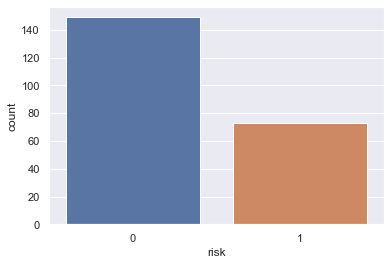

In [7]:
# check the distribution in target variable
# more low risk patients than high risk

sns.set_theme(style="darkgrid")
ax = sns.countplot(x = cl_encoded.risk)

In [8]:
cl_encoded.risk.value_counts()

0    149
1     73
Name: risk, dtype: int64

## SPLITTING INTO TRAIN AND TEST SETS

In [9]:
cl_drop = cl_encoded.drop(["sampleID", "DSS.time"], axis=1)

raw_data = cl_drop.values

X = raw_data[:, 0:-1]
y = raw_data[:, -1]

# 70% training 30% testing

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### Using only low risk to train the Autoencoder.

In [10]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)


#creating normal and fraud datasets
low_train = X_train[~y_train]
low_test = X_test[~y_test]

high_train = X_train[y_train]
high_test = X_test[y_test]

print(" No. of records in Low Train Data=",len(low_train))
print(" No. of records in HIgh Train data=",len(high_train))
print(" No. of records in Low Test Data=",len(low_test))
print(" No. of records in High Test data=",len(high_test))

 No. of records in Low Train Data= 105
 No. of records in HIgh Train data= 50
 No. of records in Low Test Data= 44
 No. of records in High Test data= 23


#### Set the training parameter values

In [11]:
nb_epoch = 50
batch_size = 64
input_dim = low_train.shape[1] #num of columns, 11
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

#### Creating the Autoencoder

In [12]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 14)                168       
_________________________________________________________________
dropout (Dropout)            (None, 14)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 35        
_________________________________________________________________
dropout_1 (Dropout)          (None, 7)                 0     

#### Define the callbacks for checkpoints and early stopping

In [13]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_risk.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

#### Compiling the Autoencoder

In [14]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

#### Training the Autoencoder

In [15]:
history = autoencoder.fit(low_train, low_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
2/2 [==============================] - 1s 373ms/step - loss: 0.8291 - accuracy: 0.0667 - val_loss: 1.2878 - val_accuracy: 0.0896

Epoch 00001: val_loss improved from inf to 1.28776, saving model to autoencoder_risk.h5
Epoch 2/50
2/2 [==============================] - 0s 32ms/step - loss: 0.8226 - accuracy: 0.0571 - val_loss: 1.2863 - val_accuracy: 0.0746

Epoch 00002: val_loss improved from 1.28776 to 1.28631, saving model to autoencoder_risk.h5
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 0.8224 - accuracy: 0.0762 - val_loss: 1.2848 - val_accuracy: 0.0597

Epoch 00003: val_loss improved from 1.28631 to 1.28485, saving model to autoencoder_risk.h5
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 0.8176 - accuracy: 0.0476 - val_loss: 1.2833 - val_accuracy: 0.0299

Epoch 00004: val_loss improved from 1.28485 to 1.28329, saving model to autoencoder_risk.h5
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.81

2/2 [==============================] - 0s 31ms/step - loss: 0.7154 - accuracy: 0.4190 - val_loss: 1.1890 - val_accuracy: 0.3881

Epoch 00036: val_loss improved from 1.19450 to 1.18901, saving model to autoencoder_risk.h5
Epoch 37/50
2/2 [==============================] - 0s 31ms/step - loss: 0.7148 - accuracy: 0.3905 - val_loss: 1.1835 - val_accuracy: 0.3881

Epoch 00037: val_loss improved from 1.18901 to 1.18347, saving model to autoencoder_risk.h5
Epoch 38/50
2/2 [==============================] - 0s 29ms/step - loss: 0.7097 - accuracy: 0.3714 - val_loss: 1.1780 - val_accuracy: 0.3881

Epoch 00038: val_loss improved from 1.18347 to 1.17802, saving model to autoencoder_risk.h5
Epoch 39/50
2/2 [==============================] - 0s 30ms/step - loss: 0.7162 - accuracy: 0.3619 - val_loss: 1.1724 - val_accuracy: 0.3881

Epoch 00039: val_loss improved from 1.17802 to 1.17239, saving model to autoencoder_risk.h5
Epoch 40/50
2/2 [==============================] - 0s 32ms/step - loss: 0.7073 -

#### Plot training and test loss

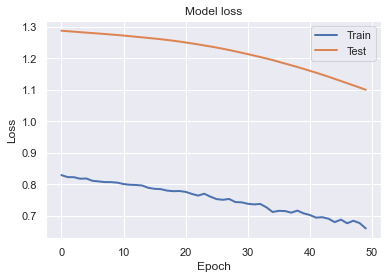

In [16]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#### Detect Anomalies on test data

In [17]:
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})

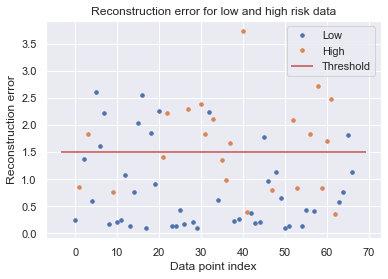

In [18]:
threshold_fixed = 1.5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "High" if name == 1 else "Low")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for low and high risk data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

#### Evaluating the performance of the anomaly detection

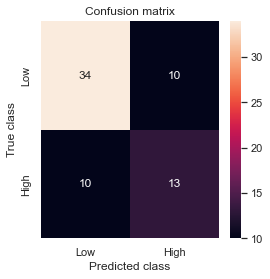

 Accuracy:  0.7014925373134329
 Recall:  0.5652173913043478
 Precision:  0.5652173913043478


In [19]:
threshold_fixed =1.5
LABELS = ['Low', 'High']

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

#### Multi Layer Percewptron

In [20]:
## took DSS.time out of the features 
## because it gives the same relevant information as risk

X = cl_encoded.drop(["sampleID", "risk", "DSS.time"], axis=1)
y = cl_encoded["risk"]

# 70% training 30% testing

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)

## Pipelines

In [21]:
from sklearn.pipeline import Pipeline

## baseline models

mlp_pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter= 500, activation= 'relu'))
    ]
)

In [22]:
## fit models
mlp_pipe.fit(X_train, y_train)
    
print("MLP Accuracy: {:.3f}".format(mlp_pipe.score(X_test,y_test)))

MLP Accuracy: 0.881


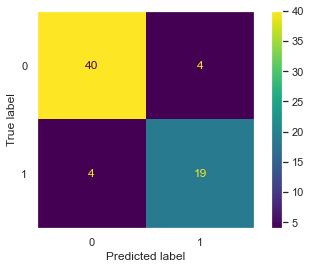

In [23]:
# check confusion matrix of best accuracy
plot_confusion_matrix(mlp_pipe, X_test, y_test, display_labels=["0", "1"])
plt.show
plt.grid(False)

#### Classification report

In [24]:
y_pred = mlp_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        44
           1       0.83      0.83      0.83        23

    accuracy                           0.88        67
   macro avg       0.87      0.87      0.87        67
weighted avg       0.88      0.88      0.88        67

